<a href="https://colab.research.google.com/github/IFuentesSR/AET_moderate_eval/blob/main/GLDAS_TWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='upbeat-imprint-269809')

In [2]:
geometry = ee.Geometry.MultiPoint(
        [[-69.06506372005273, -21.758295486762478],
         [-70.61251304538965, -30.616437051853968],
         [-70.54659507663965, -29.7236312070661],
         [-70.19503257663965, -28.861305342286464],
         [-69.84347007663965, -27.408136934282247],
         [-70.88083334720092, -31.602116408081326],
         [-70.94675131595092, -32.153797496835324],
         [-70.88632651126342, -32.474125556638484],
         [-70.84787436282592, -32.779463647852516],
         [-70.69406576907592, -33.48326821887099],
         [-71.11703940188842, -34.41850058270932],
         [-71.05661459720092, -35.059488100386716],
         [-71.65876074869948, -35.848348131973744],
         [-72.01662303845337, -36.69094471746763],
         [-72.39403570976292, -37.38960150436829]])

basins = ee.FeatureCollection('users/ignisfausto/Chile/basins')
basins = basins.filterBounds(geometry)

In [3]:
gldas = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D")
gldas = gldas.select('TWS_tavg')

In [12]:
def monthly_conversion(collection):
    def inner1(m):
        years = ee.List.sequence(2003, 2022)
        def inner2(y):
            date0 = ee.Date.fromYMD(y, m, 1)
            coll = gldas.filterDate(date0, date0.advance(1, 'month'))
            condition = ee.Algorithms.If(coll.size().eq(0),
                                         ee.Image().setMulti({'keep':0,
                                                              'system:time_start':date0.millis(),
                                                              'date':date0.format('YYYY-MM-dd')}),
                                         coll.reduce('mean').setMulti({'keep':1,
                                                                       'system:time_start':date0.millis(),
                                                                       'date':date0.format('YYYY-MM-dd')}))
            return condition
        return years.map(inner2).flatten()
    return inner1


def sampling(collection):
    def wrap(fea):
        def inner(img):
            tws = ee.Image(img).reduceRegion('mean', fea.geometry(), 27830).values().get(0)
            return ee.Feature(None,
                              {'date':img.get('date'),
                               'TWS':tws}).copyProperties(fea, fea.propertyNames())
        return collection.map(inner)
    return wrap

In [14]:
months = ee.List.sequence(1, 12)
monthly_agg = months.map(monthly_conversion(gldas))
monthly_agg = ee.ImageCollection.fromImages(monthly_agg.flatten()).filter(ee.Filter.eq('keep', 1)).sort('system:time_start')
data_tws = basins.map(sampling(monthly_agg)).flatten()
ee.batch.Export.table.toDrive(data_tws.flatten(), 'tws_gldas').start()

In [15]:
data = data_tws.getInfo()

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


cuencas = [n['properties']['NOM_CUEN'] for n in data['features']]
dates = [n['properties']['date'] for n in data['features']]
tws = [n['properties']['TWS'] for n in data['features']]
areas = [n['properties']['Area_km2'] for n in data['features']]

df = pd.DataFrame(data={'NOM_CUEN':cuencas, 'date':dates, 'TWS':tws, 'area':areas})

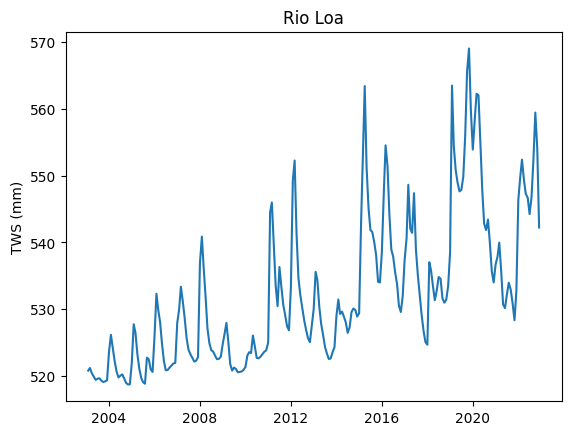

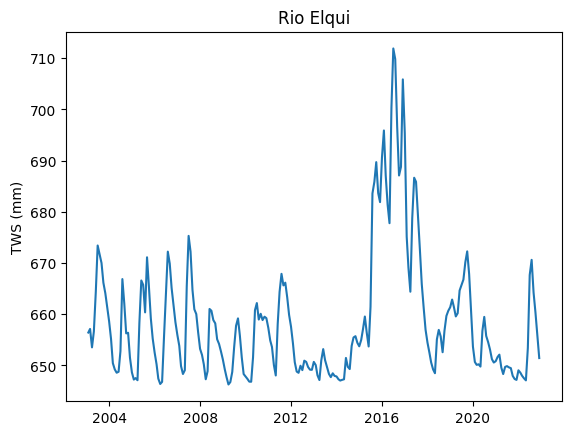

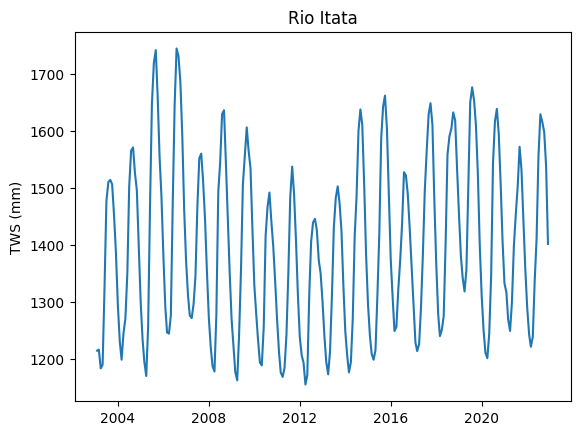

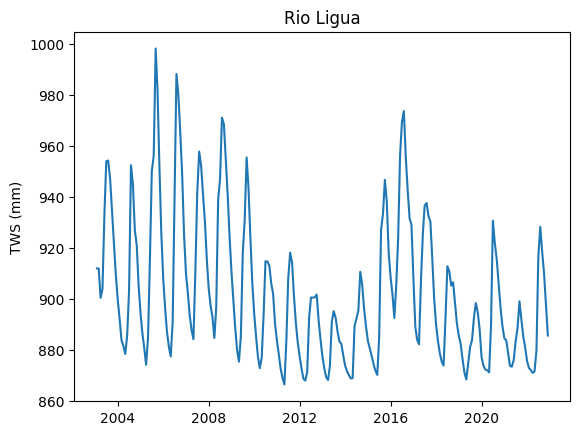

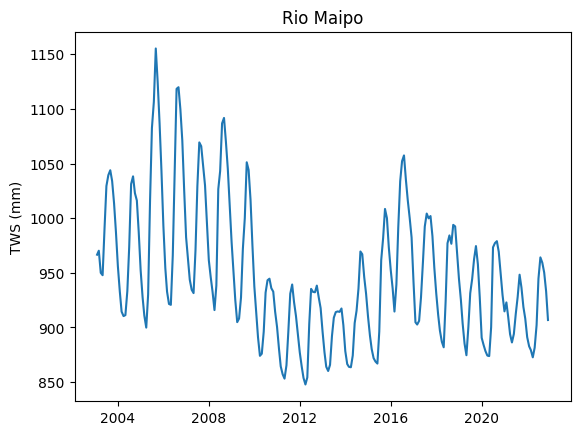

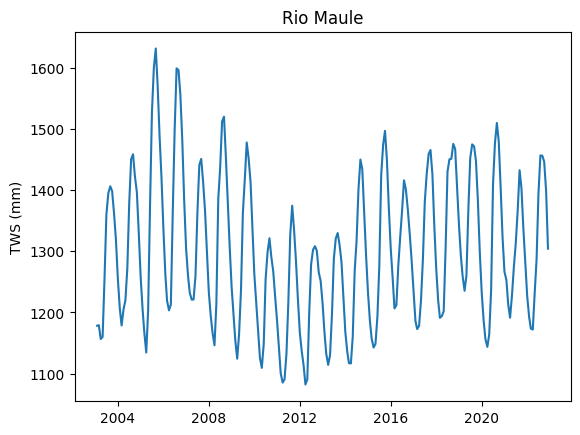

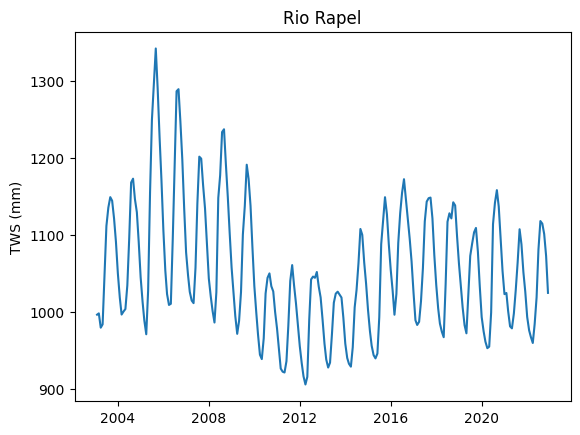

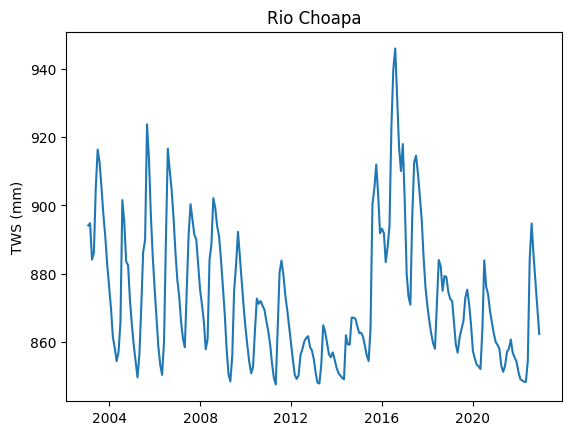

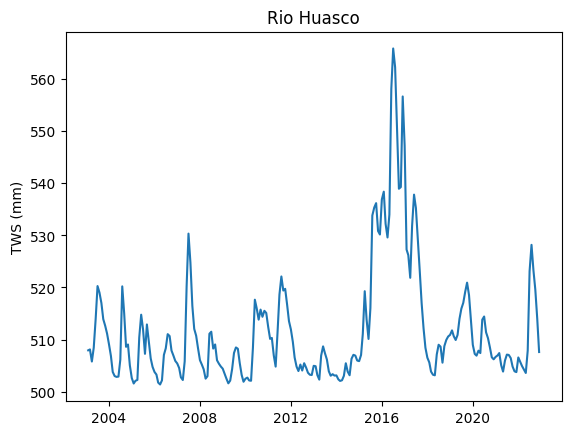

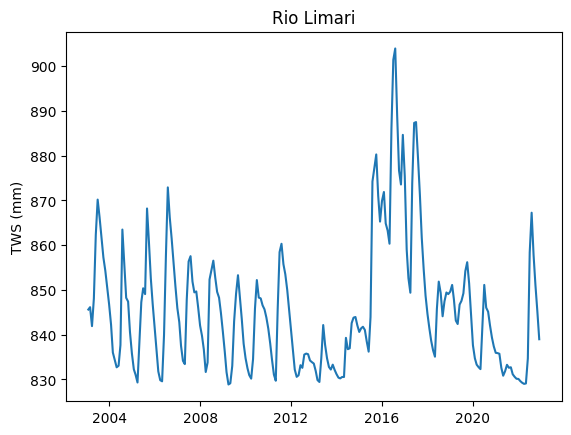

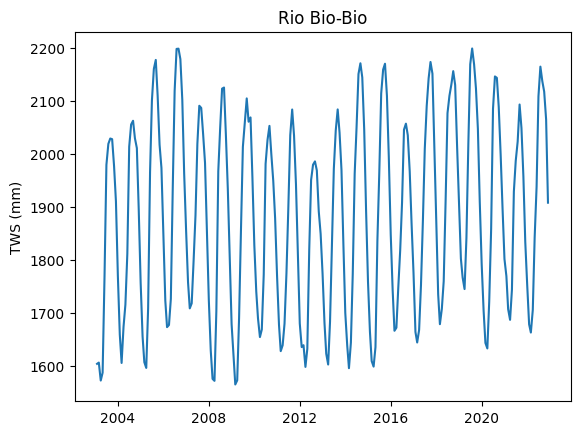

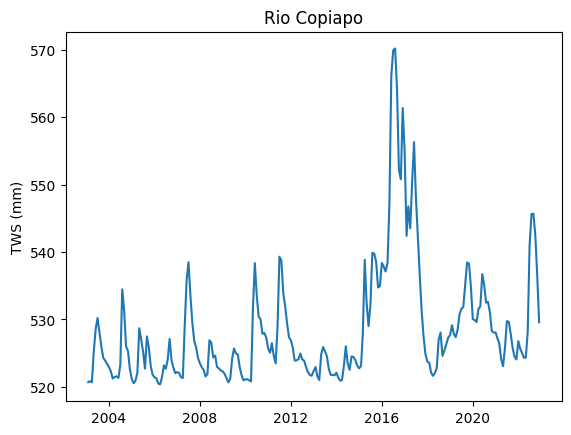

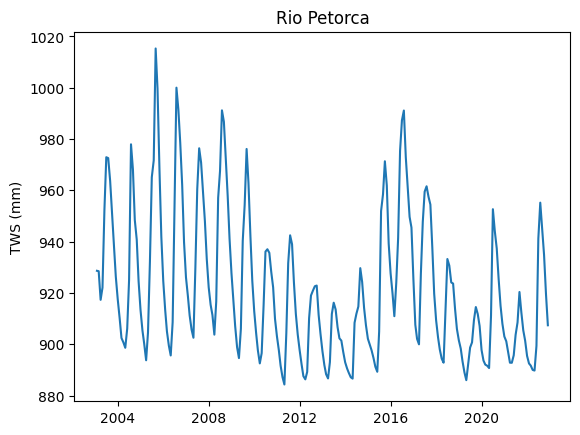

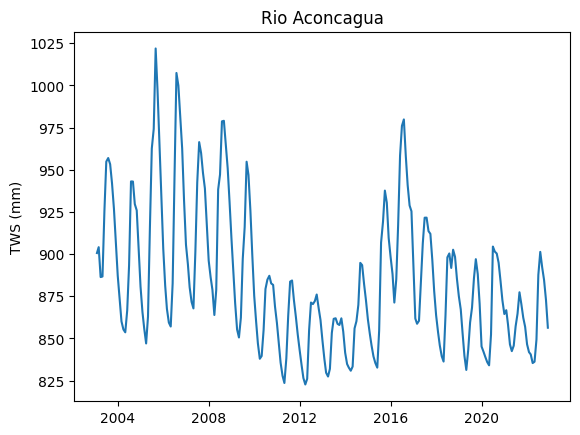

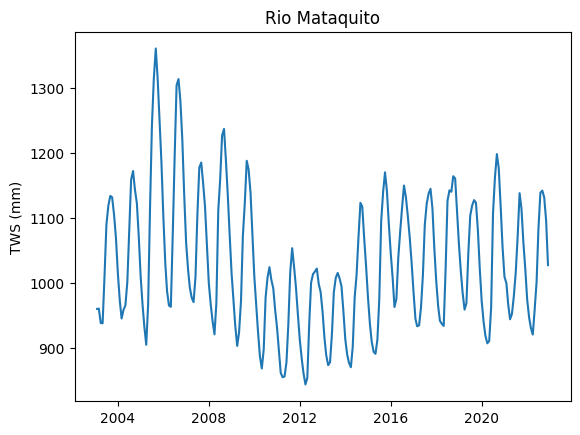

In [24]:
for n in df['NOM_CUEN'].unique():
    sub_df = df[df['NOM_CUEN'] == n]
    sub_df = sub_df.set_index(pd.to_datetime(sub_df['date']))
    plt.plot(sub_df['TWS'])
    plt.ylabel('TWS (mm)')
    plt.title(n)
    plt.show()
